<center>
    
### Прогнозирование числа просмотров объявлений на Авито
    
ПМ-1501 Брыкова Алина
   

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder,  Normalizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR
import re
import xgboost
from scipy import stats
plt.rcParams['figure.figsize'] = (12,8)
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('avito_full.csv')

### Описание набора данных и признаков

In [5]:
# Проверка, что файл прочитался нормально
data.head()

,start_time,title,price,owner_type,category,subcategory,param1,param2,param3,region,item_views
0,2016-12-27 10:38:04,Сандали фирмы Crocs,800,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Москва,27
1,2016-12-27 15:23:55,Бутсы футбольные Reebok,2000,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Омская область,9
2,2016-12-28 19:34:15,Nike hypervenom Бутсы,600,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Санкт-Петербург,105
3,2016-12-26 10:26:02,Сапоги,150,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Тульская область,28
4,2016-12-26 17:09:19,Кеды 38,500,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Самарская область,9


Каждая строка - одно объявление на платформе avito.ru (объект исследования)
<br>Каждый столбец - определенный признак объекта

<b>Описание признаков:</b>
    
<b> start_time </b> - время подачи объявления (МСК)<br>
<b>title </b>- заголовок объявления<br>
<b>price </b>- цена<br>
<b>item_id</b> - идентификатор объявления<br>
<b>owner_type</b> - тип владельца объявления (Private - частный пользователь
Company - компания; Shop - владелец магазина на Avito)<br>
<b>category</b> - категория объявления (транспорт, недвижимость и т.д.)<br>
<b>subcategory</b> - подкатегория объявления<br>
<b>param1, param2, param3 </b>- параметры объявления. Отсортированы по
нахождению в дереве категорий Авито <br>
<b>region </b>- регион размещения объявления<br>

<b>item_views</b> - целевая переменная, количество просмотров объявления до конца следующего дня с момента подачи

###   Первичный анализ данных

In [6]:
#посмотрим типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423772 entries, 0 to 423771
Data columns (total 11 columns):
start_time     423772 non-null object
title          423772 non-null object
price          423772 non-null int64
owner_type     423772 non-null object
category       423772 non-null object
subcategory    423772 non-null object
param1         406622 non-null object
param2         220506 non-null object
param3         166075 non-null object
region         423772 non-null object
item_views     423772 non-null int64
dtypes: int64(2), object(9)
memory usage: 35.6+ MB


Всего наблюдений 423772<br>
Большинство признаков имеют тип object (текстовый формат)<br>
Пропуски есть в признаках param1, param2, param3.<br>


In [7]:
data.describe() #посмотрим описательные статистики числовых признаков

,price,item_views
count,4.237720e+05,423772.000000
mean,1.312350e+06,60.310087
std,6.966541e+08,113.971829
min,0.000000e+00,0.000000
25%,5.000000e+02,14.000000
50%,2.000000e+03,28.000000
75%,9.990000e+03,59.000000
max,4.534535e+11,4140.000000


In [8]:
data.nunique()#число уникальных значений всех признаков и целевой переменной.

start_time     179915
title          293336
price           10292
owner_type          3
category           10
subcategory        51
param1            418
param2            363
param3           1341
region             84
item_views       1595
dtype: int64

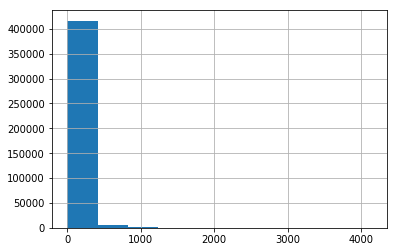

In [9]:
data['item_views'].hist() # посмотрим распределение целевой переменной

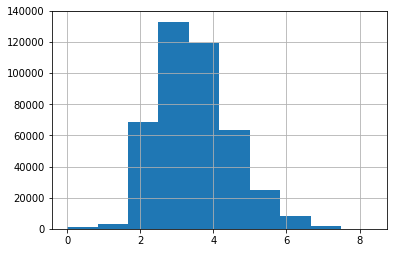

In [10]:
np.log(data['item_views']+1).hist() #логарифмируем целевую переменную,чтобы привести к нормальному виду

In [11]:
#посмотрим, какие выбросы есть в переменной item_views
data.sort_values(by='item_views',ascending=False).head(20)

,start_time,title,price,owner_type,category,subcategory,param1,param2,param3,region,item_views
223059,2016-12-26 00:24:07,"LADA Priora, 2012",170000,Private,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),Priora,Дагестан,4140
20199,2016-12-26 09:56:17,Телевизор 3D Philips 42PFL7606H/60,20000,Private,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,3761
223101,2016-12-26 18:57:43,"LADA Priora, 2010",185000,Company,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),Priora,Чеченская республика,3758
223055,2016-12-26 16:47:05,"LADA Priora, 2008",137000,Private,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),Priora,Чеченская республика,3659
332413,2016-12-26 15:45:15,"ВАЗ 21099, 2002",20000,Private,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),21099,Москва,3330
165994,2016-12-28 18:18:12,"Lamborghini Aventador, 2015",300000,Private,Транспорт,Автомобили,С пробегом,Lamborghini,Aventador,Белгородская область,3271
244863,2016-12-26 14:09:04,"Mercedes-Benz 190 (W201), 1984",15000,Private,Транспорт,Автомобили,С пробегом,Mercedes-Benz,190 (W201),Москва,3225
223288,2016-12-28 17:51:10,"LADA Priora, 2013",230000,Private,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),Priora,Чеченская республика,3153
253255,2016-12-26 17:46:59,"LADA Granta, 2012",98000,Company,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),Granta,Дагестан,3029
352078,2016-12-27 16:46:22,"ВАЗ 2110, 2006",83000,Private,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,Москва,3023


Как видим, очень много просмотров набирается у автомобилей с пробегом. Однако, есть один выброс - это объявление с телевизором, набравшее 3761 просмотр. Возможно, это по причине относительно небольшой цены на телевизор

In [12]:
y=data['title']
data[y.str.contains('Телевизор',case=False)].sort_values(by='item_views',ascending=False).head(10)
#можно сказать, что обычно телевизоры не набирают такие большие значения, как этот выброс. 
#Хотя столько просмотров может быть обусловлено тем, что оно размещено утром и поэтому у него было больше времени набрать их.

,start_time,title,price,owner_type,category,subcategory,param1,param2,param3,region,item_views
20199,2016-12-26 09:56:17,Телевизор 3D Philips 42PFL7606H/60,20000,Private,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,3761
48001,2016-12-28 20:40:51,Телевизор Supra,2500,Private,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,2177
38575,2016-12-27 18:12:47,Телевизор LG 28 дюймов,12000,Company,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,2112
20449,2016-12-28 15:49:10,"Телевизор Philips ЖК 42"" Smart, DVB-T2",19000,Company,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,2086
20245,2016-12-26 17:59:06,"Фирменный ЖК телевизор Philips 42PFL3619sd, FHD",9500,Company,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,2078
38940,2016-12-27 10:52:19,Плазменный телевизор Samsung PS51E450A1W 51 дюйм,22000,Private,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,2047
20432,2016-12-28 15:46:53,Телевизор LG (торг уместен) срочно продам,15000,Private,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,1998
20498,2016-12-26 10:27:54,Телевизор samsung,27000,Company,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,1908
20055,2016-12-28 19:48:38,Новый телевизор Thomson 46 дюймов/1080p Full HD,23000,Company,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,1899
20348,2016-12-26 14:28:48,Продам телевизор LG 55LW575S,50000,Private,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Санкт-Петербург,1847


In [13]:
data['owner_type'].value_counts()#посмотрим распределение переменной Тип собственника. Больше всего частных объявлений. 

Private    262354
Company    120952
Shop        40466
Name: owner_type, dtype: int64

###  Предобработка данных

Объединение признаков param1, param2, param3 в один describe

In [4]:
data_new = data.copy()

In [5]:
data_new['describe'] = data.param1 +' '+ data.param2 + ' ' + data.param3
data_new =  data_new.drop(['param1', 'param2', 'param3'], axis=1)

Заполним пропуски в новом признаке describe на текст 'отсутствует описание'

In [6]:
data_new = data_new.fillna('отсутствует описание')

Я решила попробовать поменять параметр, где указано время размещения объявления. Теперь это параметр, показывающий за сколько времени набралось данное количество просмотров в item_views. Для этого я написала функцию change_time. Можно было попробовать рассчитывать данные значения с помощью библиотеки datetime, однако, мне показалось, что так работает немного быстрее.

In [7]:
def change_time(x):
    return 172800 - (int(x[-2:]) + int(x[-5:-3])*60 + int(x[-8:-6])*3600)
data_new['start_time'] = data['start_time'].apply(change_time)

Найдем все английские слова, встречающиеся в title, создадим список  500 самых повторяющихся

In [8]:
result=[]
wordPattern = re.compile("((?:[a-zA-Z]+[-']?)*[a-zA-Z]+)")
for i in data['title']:
    for j in wordPattern.findall(i):
        if len(j)>=3:
            result.append(j.lower())          
dictEngW = pd.Series(result).value_counts().head(500).index.tolist()

Так как title имеет очень много уникальных значений (больше половины размера всей выборки), я попробую заменить title на индикатор, имеет ли он бренд(часто встречающиеся английские слова). (0 - нет бренда, 1 - есть бренд)

In [9]:
def title(y):
    for q in dictEngW:
        if q in y.lower():
            return 1
    return 0
    
            
data_new['title'] = data['title'].apply(title)

In [10]:
data_new['title'].value_counts().head()

0    308341
1    115431
Name: title, dtype: int64

Закодируем текстовые признаки с помощью LabelEncoder

In [11]:
encoder = LabelEncoder()
for col in ['owner_type', 'category', 'subcategory', 'describe',  'region']:
        encoder.fit(data_new[col])
        data_new[col] = encoder.transform(data_new[col])

Проверим, имеет ли логарифм целевой переменной нормальный вид

In [12]:
stats.shapiro(np.log(data[['item_views']]+1)) #можем логарифмировать целевую переменную

(0.9747441411018372, 0.0)

### Визуальный анализ данных

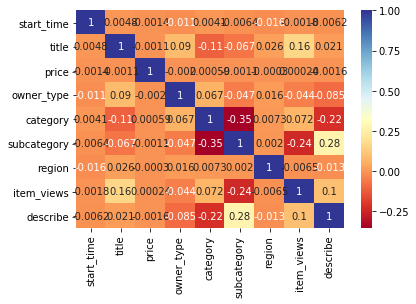

In [23]:
corr_matrix = data_new.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu');

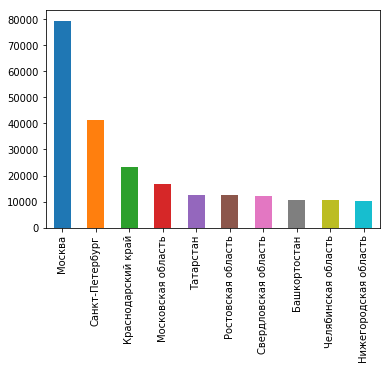

In [24]:
data['region'].value_counts().head(10).plot.bar();

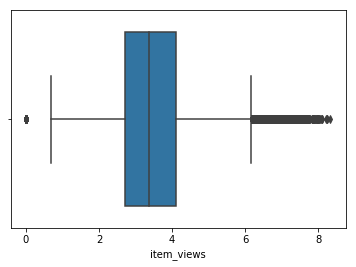

In [13]:
y = data_new['item_views']
sns.boxplot(np.log(y+1));

Удалим выбросы

In [14]:
data_new['log_views'] = np.log(y+1)

In [15]:
data_new = data_new[data_new['log_views']<6][data_new['log_views']>1]
data_new = data_new.drop(['log_views'],axis=1)
len(data_new)/len(data)

0.9789745429145862

Разделим данные на целевой столбец и столбцы признаков

In [16]:
X = data_new[['title','start_time','price','owner_type', 'category','subcategory', 'region','describe' ]]

In [17]:
y = data_new['item_views']

Создадим выборку train для обучения и отложенную выборку test для определения ошибки

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=75)

### Линейная регрессия

Построим линейную регрессию

In [31]:
model = LinearRegression().fit(x_train,np.log(y_train+1))
pred = model.predict(x_test)
mean_squared_error(y_test, np.exp(pred)-1)

3547.483246618762

Нормализуем наши признаки

In [19]:
transformer = Normalizer().fit(x_train)
x_train = transformer.transform(x_train)
transformer = Normalizer().fit(x_test)
x_test = transformer.transform(x_test)

Строим линейную регрессию по нормализованной выборке

In [ ]:
model = LinearRegression().fit(x_train,np.log(y_train+1))

Сделаем кросс-валидацию по 5 блокам, обучая модель на логарифмированной переменной и найдем среднее ошибок по блокам

In [ ]:
kf = KFold(n_splits=5)
scores = []
model = LinearRegression()
kfold = kf.split(data_new)
for  train, test in kfold:
    x1_train = data_new[train[1]:train[-1]].drop(['item_views'],axis=1)
    y1_train = data_new[train[1]:train[-1]]['item_views']
    x1_test = data_new[test[1]:test[-1]].drop(['item_views'],axis=1)
    y1_test = data_new[test[1]:test[-1]]['item_views']
    transformer = Normalizer().fit(x1_train)
    x1_train = transformer.transform(x1_train)
    transformer = Normalizer().fit(x1_test)
    x1_test = transformer.transform(x1_test)
    model = model.fit(x1_train,np.log(y1_train+1))
    pred = model.predict(x1_test) 
    scores.append(mean_squared_error(y1_test, np.exp(pred)-1))


np.mean(scores)

Построим гребневую регрессию

In [ ]:
kf = KFold(n_splits=5)
scores = []
model = Ridge(alpha=0.005, solver = 'auto')
kfold = kf.split(data_new)
for  train, test in kfold:
    x1_train = data_new[train[1]:train[-1]].drop(['item_views'],axis=1)
    y1_train = data_new[train[1]:train[-1]]['item_views']
    x1_test = data_new[test[1]:test[-1]].drop(['item_views'],axis=1)
    y1_test = data_new[test[1]:test[-1]]['item_views']
    transformer = Normalizer().fit(x1_train)
    x1_train = transformer.transform(x1_train)
    transformer = Normalizer().fit(x1_test)
    x1_test = transformer.transform(x1_test)
    model = model.fit(x1_train,np.log(y1_train+1))
    pred = model.predict(x1_test) 
    scores.append(mean_squared_error(y1_test, np.exp(pred)-1))

np.mean(scores)

In [ ]:
params = {'alpha':[0.005,0.01,0.1], 'solver' :['auto', 'sag']}
grid = GridSearchCV(model,params, scoring="neg_mean_squared_error")
grid.fit(x_train,np.log(y_train+1))

In [ ]:
grid.best_params_

### Метод K-ближайших соседей

Посмотрим как будет работать метод ближайших соседей

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=75)
transformer = Normalizer().fit(x_train)
x_train = transformer.transform(x_train)
transformer = Normalizer().fit(x_test)
x_test = transformer.transform(x_test)

neigh = KNeighborsRegressor()
knn_param = {'weights': ['uniform', 'distance'], 'n_neighbors': [ 70, 80, 90, 100, 110]}

In [38]:
np.mean(cross_val_score(neigh,x_train,y_train,scoring = 'neg_mean_squared_error',cv=5))*(-1)

2903.4413842388917

Подберем параметры с помощью GridSearch

In [39]:
grid = GridSearchCV(neigh,knn_param, scoring="neg_mean_squared_error")

In [40]:
grid.fit(x_train, y_train)
grid.best_params_

{'n_neighbors': 100, 'weights': 'distance'}

Построим модель с подобранными параметрами

In [41]:
neigh = KNeighborsRegressor(n_neighbors=100,weights = 'distance')
knn = neigh.fit(x_train,y_train)

In [43]:
np.mean(cross_val_score(neigh,x_train,y_train,scoring = 'neg_mean_squared_error',cv=5))*(-1)

2563.8266048137816

### Decision Tree

Посмотрим как будет предсказывать дерево решений

In [44]:
dt = DecisionTreeRegressor()
np.mean(cross_val_score(dt, x_train, y_train, scoring = 'neg_mean_squared_error', cv=5))*(-1)

3530.396167087017

Подберем параметр максимальной глубины

In [45]:
dt_param = {'max_depth':[5,6,7,8,9,10,11,12,13]}
grid = GridSearchCV(dt, dt_param, scoring = "neg_mean_squared_error");
grid.fit(x_train, y_train);
grid.best_params_

{'max_depth': 9}

Построим с лучшим параметром глубины

In [46]:
dt = DecisionTreeRegressor(max_depth = 9)
np.mean(cross_val_score(dt, x_train, y_train, scoring = 'neg_mean_squared_error', cv=5))*(-1)

2094.4506080043266

Ошибка намного меньше ошибки на линейной регрессии и методе ближайших соседей

### Random Forest

Попробуем построить случайный лес

In [47]:
rf = RandomForestRegressor(n_estimators = 50, max_depth = 12)
np.mean(cross_val_score(rf, x_train, y_train, scoring = 'neg_mean_squared_error', cv=5))

-1923.8918287492656

Проведем подбор параметра глубины

In [48]:
rf_param = {'max_depth':[9,12,20]}
grid = GridSearchCV(rf, rf_param, scoring = "neg_mean_squared_error");
grid.fit(x_train, y_train);

In [49]:
grid.best_params_

{'max_depth': 20}

In [22]:
rf = RandomForestRegressor(n_estimators = 120, max_depth = 20)
np.mean(cross_val_score(rf, x_train, y_train, scoring = 'neg_mean_squared_error', cv=5))

-1830.0625756575723

In [23]:
rf = RandomForestRegressor()
rf_param = {'max_depth':[20,25,30],'n_estimators':[100,120,150]}
grid = GridSearchCV(rf, rf_param, scoring = "neg_mean_squared_error");
grid.fit(x_train, y_train);

In [21]:
grid.best_params_

{'max_depth': 20, 'n_estimators': 120}

### Градиентный бустинг

Построим градиентный бустинг с помощью библиотеки xgboost

In [51]:
xgb = xgboost.XGBRegressor(n_estimators = 50, max_depth = 9)
np.mean(cross_val_score(xgb, x_train, y_train, scoring="neg_mean_squared_error", cv=5))*(-1)

1847.1714415468487

Рассмотрим разные параметры глубины

In [52]:
xgb_param = {'max_depth':[9,12,20]}
grid = GridSearchCV(xgb, xgb_param, scoring = "neg_mean_squared_error");
grid.fit(x_train, y_train);

In [53]:
grid.best_params_

{'max_depth': 12}

In [54]:
xgb = xgboost.XGBRegressor(n_estimators = 50, max_depth = 12)
np.mean(cross_val_score(xgb, x_train, y_train, scoring="neg_mean_squared_error", cv=5))*(-1)

1819.611851429459

In [55]:
xgb_param = {'max_depth':[9,12,20], 'n_estimators': [30,50,100]}
grid = GridSearchCV(xgb, xgb_param, scoring = "neg_mean_squared_error");
grid.fit(x_train, y_train);
grid.best_params_

{'max_depth': 12, 'n_estimators': 100}

In [56]:
xgb = xgboost.XGBRegressor(n_estimators = 100, max_depth = 12)
np.mean(cross_val_score(xgb, x_train, y_train, scoring="neg_mean_squared_error", cv=5))*(-1)

1811.2739868045162

Градиентный бустинг с глубиной 12 сработал лучше всех

###  Прогноз для отложенной выборки

In [59]:
xgb = xgboost.XGBRegressor(n_estimators = 100, max_depth = 12).fit(x_train,y_train)
predxgb = xgb.predict(x_test)
mean_squared_error(y_test, predxgb)

1793.45577612539

In [60]:
mean_absolute_error(y_test, predxgb)

25.317878350060326